C:\Users\bgpa4\AppData\Local\Temp\ipykernel_8156\3024102264.py:74: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


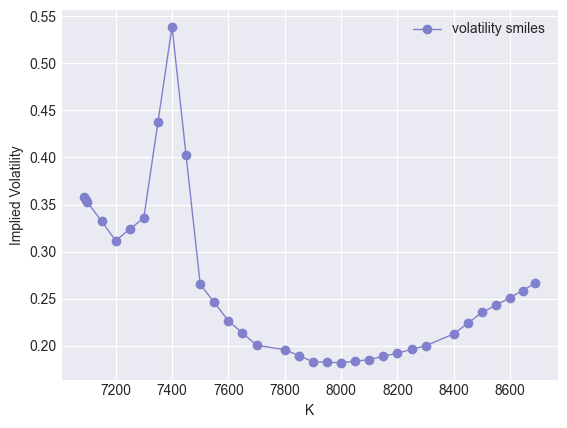

C:\Users\bgpa4\AppData\Local\Temp\ipykernel_8156\3024102264.py:87: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


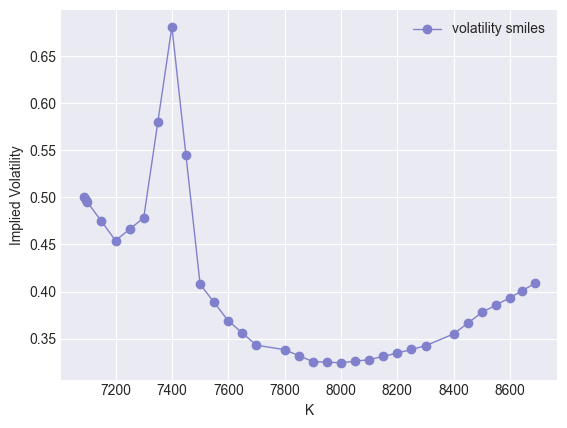

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
def Slope(X, Y, axis=1):
    sorted_idx = np.argsort(X, axis=axis)
    X = np.take_along_axis(X, sorted_idx, axis=axis)
    Y = np.take_along_axis(Y, sorted_idx, axis=axis)
    if axis==1:
        delta_X = X[:,1:] - X[:,:-1]
        delta_Y = Y[:,1:] - Y[:,:-1]
    if axis==0:
        delta_X = X[1:] - X[:-1]
        delta_Y = Y[1:] - Y[:-1]
    return delta_Y / delta_X

def recovery_curve(x, slope, y0=0.5):
    delta_x = x[1:] - x[:-1]
    delta_y = delta_x*slope
    y = np.array([delta_y[:i].sum() for i in range(1, len(x), 1)]) + y0
    y = np.hstack((np.array([y0]), y))
    return y
IVdir = 'callIV'
OCRange = 1
lower_range = 800
upper_range = 800

top_path = './../../../'

ForecastPath = top_path + 'Data/Forecast/'

file = top_path + 'Data/Interpolate/{}/{}/{}_{}.csv'.format(IVdir, OCRange, lower_range, upper_range)
if IVdir not in os.listdir(ForecastPath):
    os.mkdir(ForecastPath + '{}'.format(IVdir))

if str(OCRange) not in os.listdir(ForecastPath + '{}'.format(IVdir)):
    os.mkdir(ForecastPath + '{}/{}'.format(IVdir, OCRange))

if '{}_{}'.format(lower_range, upper_range) not in \
os.listdir(ForecastPath + '{}/{}'.format(IVdir, OCRange)):
    os.mkdir(ForecastPath + '{}/{}/{}_{}'.format(IVdir, OCRange, lower_range, upper_range))
output_dir_path = ForecastPath + '{}/{}/{}_{}/'.format(IVdir, OCRange, lower_range, upper_range)

IV_data = pd.read_csv(file, encoding='Big5', index_col=False)

#IV_data = IV_data[IV_data['到期天數'] > 2]
#IV_data = IV_data[IV_data['到期天數'] < 30]


OC = abs(np.array(IV_data['期貨開盤價'] - IV_data['期貨收盤價']))
HL = np.array(IV_data['期貨最高價'] - IV_data['期貨最低價'])
OCHL = np.vstack((OC, HL)).T
expirty_days = np.array(IV_data['到期天數'])




IV_matrix = np.array(IV_data)
K_num = len(np.where(IV_matrix[0,0] == IV_matrix)[0])
K_closing = np.array(IV_data['履約價(收盤價)'])
K_closing = np.reshape(K_closing, (-1, K_num))
IV_closing = np.array(IV_data['隱含波動率(收盤價)'])
IV_closing = np.reshape(IV_closing, (-1, K_num))
K_IVslope_closing = Slope(X=K_closing, Y=IV_closing, axis=1)

K_settlement = np.array(IV_data['履約價(結算價)'])
K_settlement = np.reshape(K_settlement, (-1, K_num))
IV_settlement = np.array(IV_data['隱含波動率(結算價)'])
IV_settlement = np.reshape(IV_settlement, (-1, K_num))
K_IVslope_settlement = Slope(X=K_settlement, Y=IV_settlement, axis=1)


k = 20
plt.style.use('seaborn-darkgrid')
plt.plot(K_settlement[k], IV_settlement[k], lw=1, ls='-', marker='o', c=[0.5, 0.5, 0.8], label='volatility smiles')
#plt.plot([Udata[k,4]]*2, [Kmin, Kmax], lw=1, ls='--', c=[0.8, 0.5, 0.5], label='futures price')
plt.xlabel('K')
plt.ylabel('Implied Volatility')
plt.legend()
plt.show()

#x = np.arange(1, K_num+1, 1)
#y_right = 0.2
#y = np.array([K_IVslope[k,:i].sum() for i in range(1, K_num, 1)]) + y_right
#y = np.hstack((np.array([y_right]), y))
y = recovery_curve(K_settlement[k], K_IVslope_settlement[k])
plt.style.use('seaborn-darkgrid')
plt.plot(K_settlement[k], y, lw=1, ls='-', marker='o', c=[0.5, 0.5, 0.8], label='volatility smiles')
#plt.plot([Udata[k,4]]*2, [Kmin, Kmax], lw=1, ls='--', c=[0.8, 0.5, 0.5], label='futures price')
plt.xlabel('K')
plt.ylabel('Implied Volatility')
plt.legend()
plt.show()

若$X=[x_1, x_2,\dots x_n     ]$  
則 $TimeSeriesData(X, 30)= [[x_1, x_2,\dots x_{30}],\quad [x_2, x_3,\dots x_{31}]\dots [x_{n-30}, x_{n-29},\dots x_{n-1}]],\quad [x_{31}, x_{32},\dots x_n     ]$  

In [56]:
def TimeSeriesData(X, seq_length):
    X_train = np.zeros((len(X)-seq_length, seq_length, len(X[0])))
    y_train = np.zeros((len(X)-seq_length, len(X[0])))
    for i in range(len(X) - seq_length):
        X_train[i] = X[i:i+seq_length]
        y_train[i] = (X[i+seq_length])
    return np.array(X_train), np.array(y_train)
seq_length = 7
magnification_slope = 10000
IV_matrix_forecast = IV_matrix[seq_length*K_num:]
#收盤價
Inputs_closing_slope, Ouputs_closing = TimeSeriesData(K_IVslope_closing*magnification_slope, seq_length=seq_length)

Inputs_OHLC = OCHL[range(0, len(IV_matrix), K_num)]
Inputs_OHLC = np.array([Inputs_OHLC[i:i+seq_length+1] for i in range(len(Inputs_OHLC)-seq_length)])
Inputs_OHLC = Inputs_OHLC.astype(float)


Inputs_expirty = expirty_days[range(0, len(IV_matrix), K_num)]
Inputs_expirty = np.array([Inputs_expirty[i:i+seq_length+1] for i in range(len(Inputs_expirty)-seq_length)])
Inputs_expirty = Inputs_expirty.astype(float)
Inputs_expirty = np.reshape(Inputs_expirty, (Inputs_expirty.shape[0], Inputs_expirty.shape[1], 1))

train_size = int(len(Inputs_closing_slope)*0.8)
X_train_closing = Inputs_closing_slope[:train_size]
OHLC_train = Inputs_OHLC[:train_size]
Inputs_expirty_train = Inputs_expirty[:train_size]
y_train_closing = Ouputs_closing[:train_size]
X_test_closing = Inputs_closing_slope[train_size:]
y_test_closing = Ouputs_closing[train_size:]
IV_matrix_test = IV_matrix_forecast[K_num*train_size:]
OHLC_test = Inputs_OHLC[train_size:]
Inputs_expirty_test = Inputs_expirty[train_size:]

#結算價
Inputs_settlement, Ouputs_settlement = TimeSeriesData(K_IVslope_settlement*magnification_slope, seq_length=seq_length)
train_size = int(len(Inputs_settlement)*0.8)
X_train_settlement = Inputs_settlement[:train_size]
y_train_settlement = Ouputs_settlement[:train_size]
X_test_settlement = Inputs_settlement[train_size:]
y_test_settlement = Ouputs_settlement[train_size:]


In [57]:
from keras.models import Model
from keras.layers import Input, Dense, LSTM, concatenate
from keras.optimizers import Adam

# 定義第一個LSTM模型
input_lstm_OHLC = Input(shape=OHLC_train.shape[1:])
hidden1_OHLC = LSTM(500, return_sequences=True, activation='relu')(input_lstm_OHLC)
hidden2_OHLC = LSTM(200, activation='relu')(hidden1_OHLC)
output_OHLC = Dense(100)(hidden2_OHLC)

# 定義第二個LSTM模型
input_lstm_slope = Input(shape=X_train_settlement.shape[1:])
#lstm1 = LSTM(200, return_sequences=True, activation='relu')(input_slope)
hidden1_slope = LSTM(128, activation='relu')(input_lstm_slope)
output_slope = Dense(100)(hidden1_slope)

# 定義第三個LSTM模型
input_lstm_expiry = Input(shape=Inputs_expirty_train.shape[1:])
#hidden1_expiry = LSTM(128, return_sequences=True, activation='relu')(input_lstm_expiry)
hidden2_expiry = LSTM(128, activation='relu')(input_lstm_expiry)
output_expiry = Dense(64)(hidden2_expiry)

# 合併兩個模型的輸出
#merged = concatenate([output_ann, dense_lstm], axis=-1)
merged = concatenate([output_OHLC, output_slope, output_expiry], axis=-1)

# 加入一個Dense層
dense1 = Dense(512, activation='relu')(merged)
dense2 = Dense(256, activation='relu')(dense1)
# 最終輸出層
output = Dense(y_train_closing.shape[1])(dense2)

# 定義模型
model = Model(inputs=[input_lstm_OHLC, input_lstm_slope, input_lstm_expiry], outputs=output)


model.compile(loss='mse', optimizer = 'adam', metrics=['mse'])

# 顯示模型結構
#model.summary()



# 訓練模型
model.fit([OHLC_train, X_train_settlement, Inputs_expirty_train], y_train_settlement, epochs=100, \
          batch_size=3000, validation_split=0.2)

Epoch 1/100
1/1 [==============================] - 6s 6s/step - loss: 7.2586 - mse: 7.2586 - val_loss: 10.5247 - val_mse: 10.5247
Epoch 2/100
1/1 [==============================] - 1s 795ms/step - loss: 3.4765 - mse: 3.4765 - val_loss: 8.3449 - val_mse: 8.3449
Epoch 3/100
1/1 [==============================] - 1s 793ms/step - loss: 2.3221 - mse: 2.3221 - val_loss: 5.8322 - val_mse: 5.8322
Epoch 4/100
1/1 [==============================] - 1s 750ms/step - loss: 2.1241 - mse: 2.1241 - val_loss: 3.1472 - val_mse: 3.1472
Epoch 5/100
1/1 [==============================] - 1s 782ms/step - loss: 1.9900 - mse: 1.9900 - val_loss: 2.4887 - val_mse: 2.4887
Epoch 6/100
1/1 [==============================] - 1s 782ms/step - loss: 1.8057 - mse: 1.8057 - val_loss: 3.3021 - val_mse: 3.3021
Epoch 7/100
1/1 [==============================] - 1s 828ms/step - loss: 1.7433 - mse: 1.7433 - val_loss: 3.2492 - val_mse: 3.2492
Epoch 8/100
1/1 [==============================] - 1s 818ms/step - loss: 1.6585 - ms

In [62]:
model.fit([OHLC_train, X_train_settlement, Inputs_expirty_train], y_train_settlement, epochs=10, batch_size=3000, validation_split=0.2)

Epoch 1/10
1/1 [==============================] - 1s 866ms/step - loss: 0.2860 - mse: 0.2860 - val_loss: 0.7092 - val_mse: 0.7092
Epoch 2/10
1/1 [==============================] - 1s 803ms/step - loss: 0.2874 - mse: 0.2874 - val_loss: 0.8414 - val_mse: 0.8414
Epoch 3/10
1/1 [==============================] - 1s 776ms/step - loss: 0.2795 - mse: 0.2795 - val_loss: 0.8049 - val_mse: 0.8049
Epoch 4/10
1/1 [==============================] - 1s 773ms/step - loss: 0.2733 - mse: 0.2733 - val_loss: 0.8037 - val_mse: 0.8037
Epoch 5/10
1/1 [==============================] - 1s 779ms/step - loss: 0.2723 - mse: 0.2723 - val_loss: 0.8877 - val_mse: 0.8877
Epoch 6/10
1/1 [==============================] - 1s 776ms/step - loss: 0.2750 - mse: 0.2750 - val_loss: 0.8140 - val_mse: 0.8140
Epoch 7/10
1/1 [==============================] - 1s 841ms/step - loss: 0.2766 - mse: 0.2766 - val_loss: 0.9665 - val_mse: 0.9665
Epoch 8/10
1/1 [==============================] - 1s 858ms/step - loss: 0.2723 - mse: 0.27

In [63]:
test_loss = model.evaluate([OHLC_test, X_test_settlement, Inputs_expirty_test], y_test_settlement)
print("Test Loss:", test_loss)

# 查看測試輸出
y_pred_settlement = model.predict([OHLC_test, X_test_settlement, Inputs_expirty_test])



18/18 [==============================] - 0s 11ms/step - loss: 0.4921 - mse: 0.4921
Test Loss: [0.4921002686023712, 0.4921002686023712]
18/18 [==============================] - 0s 10ms/step


In [59]:
columns_names = ['履約價(收盤價)', '履約價(結算價)', '隱含波動率(收盤價)', '隱含波動率(結算價)']
column_index = [IV_data.columns.get_loc(col) for col in columns_names]
ForecastIV = np.zeros(((len(y_pred_settlement), K_num)))



for i in range(len(y_pred_settlement)):
    x = IV_matrix_test[i*K_num:(i+1)*K_num, column_index[1]]
    v0 = IV_matrix_test[i*K_num, column_index[3]]
    ForecastIV[i] = recovery_curve(x, y_pred_settlement[i]/(magnification_slope), y0=v0)
ForecastIV = np.reshape(ForecastIV,(-1,1))
Forecast_matrix  = np.hstack((IV_matrix_test, ForecastIV))
column = np.hstack((IV_data.columns.to_numpy(), np.array(['預測隱含波動率(結算價)'])))
Forecast_Data = pd.DataFrame(data=Forecast_matrix, columns=column)


Forecast_Data.to_csv(output_dir_path + 'sRange04.csv', index=False, encoding='Big5')